## Reliability Diagram of Things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import librosa.display
import util as ut
import numpy as np
import os
import jams
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

In [3]:
def chord_calib_set():
    test_set = ut.ChordsTestSet()

    ## Open all the saved npz files (crema outputs) and save them in 2 big arrays x_all and y_all

    l = len(test_set)

    x_all, y_all = ([], [])
    first_iter = True
    for i in tqdm(range(l)):
        data = np.load(test_set.npz_fp(i))
        if first_iter:
            first_iter = False
            x_all = data['x'][:len(y_all)]
            y_all = data['y'][:len(x_all)] if data['y'].ndim == 1 else data['y'][0, :len(x_all)]
        else:
            new_y = data['y'][:len(data['x'])] if data['y'].ndim == 1 else data['y'][0, :len(data['x'])]

            x_all = np.concatenate((x_all, data['x'][:len(new_y), :]), axis=0)
            y_all = np.concatenate((y_all, new_y), axis=0)
    
    return x_all, y_all

In [64]:
def chord_calib_set_small():
    test_set = ut.ChordsTestSet()

    ## Open all the saved npz files (crema outputs) and save them in 2 big arrays x_all and y_all

    l = np.arange(len(test_set))

    x_all, y_all = ([], [])
    first_iter = True
    for i in tqdm(l[-15:]):
        data = np.load(test_set.npz_fp(i))
        if first_iter:
            first_iter = False
            x_all = data['x'][:len(y_all)]
            y_all = data['y'][:len(x_all)] if data['y'].ndim == 1 else data['y'][0, :len(x_all)]
        else:
            new_y = data['y'][:len(data['x'])] if data['y'].ndim == 1 else data['y'][0, :len(data['x'])]

            x_all = np.concatenate((x_all, data['x'][:len(new_y), :]), axis=0)
            y_all = np.concatenate((y_all, new_y), axis=0)
    
    return x_all, y_all

In [4]:
x_all, y_all = chord_calib_set()

100%|██████████| 244/244 [00:01<00:00, 125.22it/s]


In [65]:
cps, cls = chord_calib_set_small()
ccs = ut.CalibrationBenchmark(cps, cls, m=15)

100%|██████████| 15/15 [00:00<00:00, 495.23it/s]


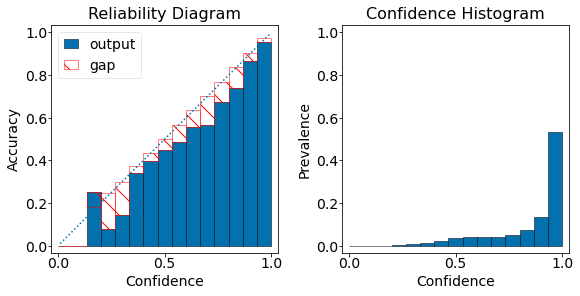

In [66]:
plot_rd(acc=ccs.bin_accuracy(), conf=ccs.bin_confidence(), hist=ccs.hist())

In [5]:
chord_calib = ut.CalibrationBenchmark(x_all, y_all, m=15)

In [55]:
def x_ticks(m=15):
    posts = np.linspace(0,1,num=m+1)
    bin_center = (posts[:-1] + posts[1:]) / 2
    width = posts[1]
    return bin_center, width

def plot_rd(acc, conf, hist, fname=None):
    x, width = x_ticks(15)
    fig, axs = plt.subplots(1, 2 ,figsize=(8, 4))
    ax, axh = axs
    ax.plot([0.01,0.99], [0.01,0.99], ':')
    ax.bar(x, acc, width, edgecolor='k', label='output')
    ax.bar(x, conf - acc, width, acc, edgecolor='r', fill=False, hatch='\\', label='gap')

    ax.axis('equal')
    ax.set(xlabel='Confidence', ylabel='Accuracy', xlim=(0,1), ylim=(0,1),
           title='Reliability Diagram')
    ax.legend()
    
    axh.bar(x, hist / hist.sum(), width, edgecolor='k')
    axh.axis('equal')
    axh.set(xlabel='Confidence', ylabel='Prevalence', xlim=(0,1), ylim=(0,1),
           title='Confidence Histogram')
    
    if fname: 
        fig.savefig(fname)
    plt.show()

In [8]:
chord_raw = ut.CalibrationBenchmark(x_all, y_all, m=15)
chord_calib = ut.CalibrationBenchmark(ut.calibrate_root(x_all), y_all, m=15)

In [30]:
plt.style.use('./bauhaus.mplstyle')

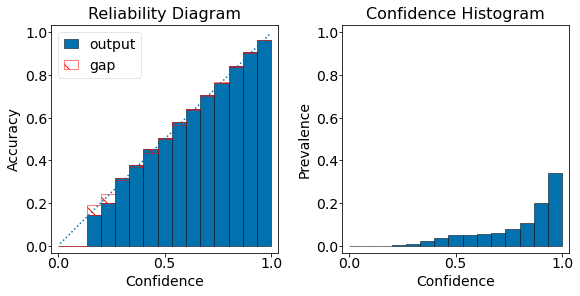

In [56]:
plot_rd(chord_calib.bin_accuracy(), chord_calib.bin_confidence(), chord_calib.hist())

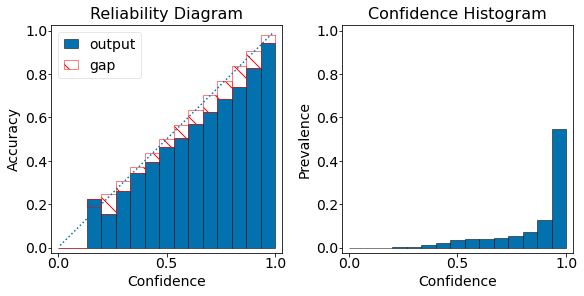

In [71]:
plot_rd(chord_raw.bin_accuracy(), chord_raw.bin_confidence(), chord_raw.hist(), fname='rd.pdf')

In [23]:
def madmom_calib_set():
    pred_list = []
    label_list = []
    file_list = ut.glob(os.path.join('/scratch/qx244/data/gskey/augmentation', '*.npy'))
    for f in tqdm(file_list):
        jams_path = f.rsplit('.', 1)[0] + '.jams'
        pred_list.append(np.load(f))
        jam = jams.load(jams_path)
        tonic = jam.search(namespace='key_mode')[0].to_dataframe().value[0]
        label_list.append((librosa.note_to_midi(tonic)) % 12)
        
    pred_all = np.concatenate(pred_list, axis=0)
    label_all = (np.array(label_list) + 3) % 12 # So that bin 0 is A to match with madmom
    
    return pred_all, label_all

In [24]:
madmom_pred, madmom_label = madmom_calib_set()

100%|██████████| 6612/6612 [00:12<00:00, 534.39it/s]


In [25]:
madmom_folded = ut.key_marg_add_logit(madmom_pred)
madmom_added = ut.key_marg_simple_add(madmom_pred)

In [26]:
folded_raw = ut.CalibrationBenchmark(madmom_folded, madmom_label)
added_raw = ut.CalibrationBenchmark(madmom_added, madmom_label)
folded_c = ut.CalibrationBenchmark(ut.better_calibrate(0.7806331984345791, madmom_folded), madmom_label)
added_c = ut.CalibrationBenchmark(ut.better_calibrate(1.2068284903223008, madmom_added), madmom_label)

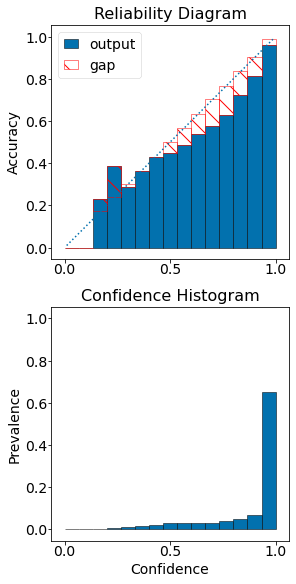

In [44]:
plot_rd(folded_raw.bin_accuracy(), folded_raw.bin_confidence(), folded_raw.hist())

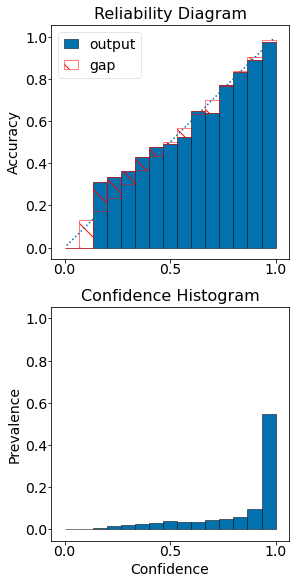

In [45]:
plot_rd(folded_c.bin_accuracy(), folded_c.bin_confidence(), folded_c.hist())

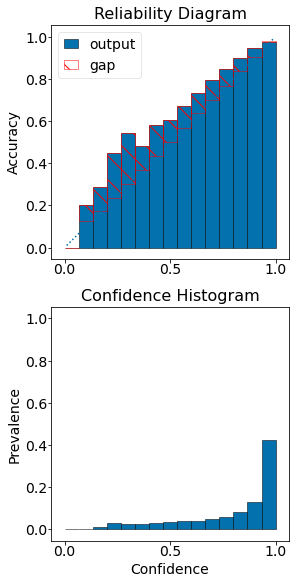

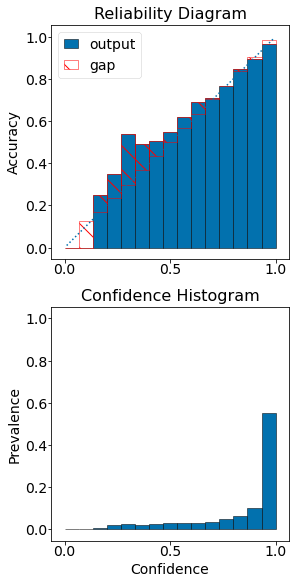

In [46]:
plot_rd(added_raw.bin_accuracy(), added_raw.bin_confidence(), added_raw.hist())
plot_rd(added_c.bin_accuracy(), added_c.bin_confidence(), added_c.hist())

## ROCK CORPUS